In [1]:
import pandas as pd
import numpy as np
# import sys
# sys.path.append("/Users/n.y.alenkin/.local/bin")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

In [3]:

test_classify = pd.read_csv(r'classify/test_clf.csv')
train_classify = pd.read_csv(r'classify/train_clf.csv')
# Преобразуем данные в numpy массивы
X_train = np.array(train_classify[['a', 'b', 'c']])
y_train = np.array(train_classify['y'])

# Количество признаков
n_features = X_train.shape[1]

# Создаем модель
with pm.Model() as logistic_model:
    # Параметры модели
    weights = pm.Normal('weights', mu=0, shape=n_features)
    intercept = pm.Normal('intercept', mu=0)

    # Логистическая функция
    logits = pm.math.dot(X_train, weights) + intercept

    # Логистическая функция связи
    probability = pm.math.sigmoid(logits)
    θ = pm.Deterministic('θ', probability)
    # Бинарная логистическая регрессия
    y_observed = pm.Bernoulli('y_observed', p=θ, observed=y_train)

    # Сэмплирование
    trace = pm.sample(1000, tune=1000)

    
posterior_0 = trace.posterior.stack(samples=("chain", "draw"))
def classify(X, threshold, posterior_0):
    """
    Моя классификационная функция
    """
    X = np.array(X)
    μ = posterior_0['intercept'].mean().values + posterior_0['weights'].mean(axis=1).values.T @ np.transpose(X)
    prob = 1 / (1 + np.exp(-μ)) 
    return prob, np.where(prob >= threshold,1,0)


def calculate_accuracy(predicted_values, true_values):
    """
    Вычисляет точность (accuracy) между двумя векторами предсказанных и истинных значений.

    :param predicted_values: Список или массив с предсказанными значениями.
    :param true_values: Список или массив с истинными значениями.
    :return: Точность в диапазоне от 0 до 1.
    """
    if len(predicted_values) != len(true_values):
        raise ValueError("Длины векторов должны быть одинаковыми")

    correct_predictions = 0
    total_predictions = len(true_values)

    for predicted, true in zip(predicted_values, true_values):
        if predicted == true:
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy


for i in range(0, 10):
    b = i*(1.0/10)
    prob, pred = classify(X_train, b, posterior_0)
    print(b)
    print(calculate_accuracy(pred, y_train))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [weights, intercept]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


0.0
0.51
0.1
0.82
0.2
0.92
0.30000000000000004
0.92
0.4
0.96
0.5
0.97
0.6000000000000001
0.96
0.7000000000000001
0.87
0.8
0.8
0.9
0.71


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'weights'}>,
        <Axes: title={'center': 'weights'}>]], dtype=object)

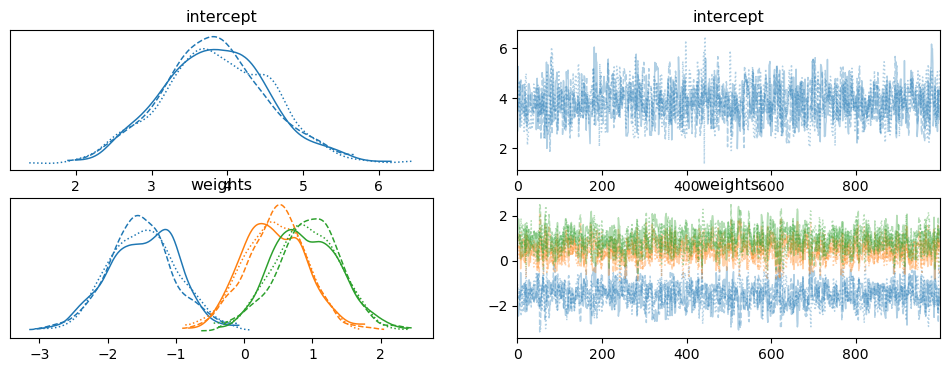

In [4]:
az.plot_trace(trace, var_names = ['intercept','weights'])

Предсказание теста

In [5]:
classify(X_test, 0.5, posterior_0)[1]

NameError: name 'X_test' is not defined

In [7]:
from sklearn.metrics import accuracy_score
y_true = pd.read_csv('test_Y_true_clf.csv')
accuracy_score(y_true, classify(X_test, 0.5, posterior_0)[1])

NameError: name 'X_test' is not defined

Задание 2

In [8]:
# Define priors for class 1 and sample the posterior
with pm.Model() as lda_class_1:
    mean_1 = pm.Normal('mean_1', mu=0, sigma=20, shape=2)
    features_class_1 = pm.Normal('features_class_1', mu=mean_1, sigma=0.63, observed=X_train[y_train == 0][:, [0, 1]])
    trace_class_1 = pm.sample(2000, chains=4, cores=4)

# Define priors for class 2 and sample the posterior
with pm.Model() as lda_class_2:
    mean_2 = pm.Normal('mean_2', mu=0, sigma=20, shape=2)
    features_class_2 = pm.Normal('features_class_2', mu=mean_2, sigma=0.63, observed=X_train[y_train == 1][:, [0, 1]])
    trace_class_2 = pm.sample(2000, chains=4, cores=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_1]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_2]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.


In [9]:
def calculate_mean(trace, class_idx, feature_idx):
    return trace.posterior[f'mean_{class_idx}'].mean(axis=0).mean(axis=0)[feature_idx].item()

μ_11 = calculate_mean(trace_class_1, 1, 0)
μ_12 = calculate_mean(trace_class_1, 1, 1)
μ_21 = calculate_mean(trace_class_2, 2, 0)
μ_22 = calculate_mean(trace_class_2, 2, 1)

def predict_class(X, μ_11, μ_12, μ_21, μ_22):
    predictions = []
    for i in X:
        first = (i[0] - μ_11) ** 2 + (i[1] - μ_12) ** 2
        second = (i[0] - μ_21) ** 2 + (i[1] - μ_22) ** 2
        predictions.append(0 if first < second else 1)
    return predictions

y_train_pred_lda = predict_class(X_train, μ_11, μ_12, μ_21, μ_22)


In [10]:
calculate_accuracy(y_train_pred_lda, y_train)

0.96

Предсказание теста

In [11]:
predict_class(X_test, μ_11, μ_12, μ_21, μ_22)

NameError: name 'X_test' is not defined

In [12]:
from sklearn.metrics import accuracy_score
y_true = pd.read_csv('test_Y_true_clf.csv')
accuracy_score(y_true, classify(X_test, 0.5, posterior_0)[1])

NameError: name 'X_test' is not defined